In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path_folder=os.path.normcase(r'C:\Users\dell\Downloads\Titanic-maching-learning-from-disaster')
train_data_origin=pd.read_csv(os.path.join(path_folder,'train.csv'),sep=',')
test_data_origin=pd.read_csv(os.path.join(path_folder,'test.csv'),sep=',')

In [3]:
def deal_ticket_fare(df):
    '''
    计算每张票有几人共享，以及每人花费的船票钱
    
    paramters:
        df--dataframe，待处理的数据表
        
    return:
        df_count--处理后，添加新列的数据表
    '''
    num_of_tickets=df[['Ticket']].groupby(df['Ticket']).count()
    num_of_tickets.columns=['num_of_tickets']
    df_count=df.merge(num_of_tickets,left_on='Ticket',right_index=True,how='left')
    df_count['fare_per_ticket']=df_count['Fare']/df_count['num_of_tickets']
    return df_count

In [4]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    from sklearn.model_selection import learning_curve
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)#train_scores size (n_ticks,n_cv_folds)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 's-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [5]:
# 计算 预测准确率
def compute_acc(y,y_pred):
    '''
        计算预测精确度
        input:
            y--true label
            y_pred-- predicted label
        return:
            accuracy--精确度
    '''
    y_pred_class=np.where(y_pred>=0.5,1,0)
    pred_accuracy=(y==y_pred_class).sum()/len(y)    
    return pred_accuracy

In [6]:
cols=['Sex_T','Embarked_T','Age','Fare','fare_per_ticket','num_of_tickets','Pclass','SibSp','Parch']

In [7]:
train_data_count=deal_ticket_fare(train_data_origin)
train_data_count.reindex(columns=cols).head(1)

,Sex_T,Embarked_T,Age,Fare,fare_per_ticket,num_of_tickets,Pclass,SibSp,Parch
0,NaN,NaN,22.0,7.25,7.25,1,3,1,0


In [8]:
#train_data_count=deal_ticket_fare(train_data)
train_data_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null object
Age                714 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           889 non-null object
num_of_tickets     891 non-null int64
fare_per_ticket    891 non-null float64
dtypes: float64(3), int64(6), object(5)
memory usage: 97.5+ KB


In [9]:
#  categorical type data
trans_sex={'male':0,'female':1}
trans_embarked={'S':0,'C':1,'Q':2}

train_data_count['Sex_T']=train_data_count['Sex'].map(trans_sex)
#from sklearn.impute import MissingIndicator
#indicator=MissingIndicator(missing_values=np.nan)
#train_missing_indicator=indicator.fit_transform(train_data_count)
from sklearn.impute import SimpleImputer
imp1=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
train_data_count['Embarked']=imp1.fit_transform(train_data_count[['Embarked']])
imp2=SimpleImputer(missing_values=np.nan,strategy='mean')
train_data_count['Age']=imp2.fit_transform(train_data_count[['Age']])
train_data_count['Embarked_T']=train_data_count['Embarked'].map(trans_embarked).astype(np.int)
cols=['Sex_T','Embarked_T','Age','Fare','fare_per_ticket','num_of_tickets','Pclass','SibSp','Parch']
X_train_data=train_data_count.reindex(columns=cols).values
y_train_data=train_data_count['Survived'].ravel()

In [10]:
test_data_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [11]:
test_data_count=deal_ticket_fare(test_data_origin)
test_data_count['Sex_T']=test_data_count['Sex'].map(trans_sex)
test_data_count['Embarked']=imp1.transform(test_data_count[['Embarked']])
test_data_count['Embarked_T']=test_data_count['Embarked'].map(trans_embarked).astype(np.int)
test_data_count['Age']=imp2.transform(test_data_count[['Age']])
X_test_data=test_data_count.reindex(columns=cols).values

In [12]:
import lightgbm as lgb
train_data=lgb.Dataset(X_train_data,label=y_train_data,categorical_feature=[0,1])
#param={'num_leaves':14,'num_iterations':400,'objective':'binary','metric':'binary_error'}
param={'objective':'binary','metric':'binary_error'}
scores_dict=lgb.cv(param,train_data,num_boost_round=1000,nfold=5,early_stopping_rounds=10,verbose_eval=10)

[10]	cv_agg's binary_error: 0.190769 + 0.0299161
[20]	cv_agg's binary_error: 0.175114 + 0.0293942
[30]	cv_agg's binary_error: 0.170601 + 0.0279258
[40]	cv_agg's binary_error: 0.16384 + 0.0260488
[50]	cv_agg's binary_error: 0.169439 + 0.0266665


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [13]:
1-np.array(scores_dict['binary_error-mean'])

array([0.61616491, 0.69022877, 0.7856164 , 0.79461137, 0.79800113,
       0.79913735, 0.7980074 , 0.79687118, 0.80022941, 0.80923095,
       0.81145923, 0.80921197, 0.80809472, 0.81032929, 0.81482381,
       0.81708363, 0.81708363, 0.8215529 , 0.82156553, 0.82488589,
       0.82826937, 0.83052291, 0.82600948, 0.82488589, 0.82487326,
       0.8271268 , 0.8271395 , 0.82826937, 0.82827572, 0.82939931,
       0.83164657, 0.83054188, 0.82716475, 0.83165285, 0.83615993,
       0.8327828 , 0.8305356 , 0.83503641, 0.83391909, 0.83616   ,
       0.84064818])

In [15]:
print (len(scores_dict['binary_error-mean']), 1-scores_dict['binary_error-mean'][-1])

41 0.8406481766175955


In [16]:
def compute_cross_val_score(param,X,y,cv=3,valid_sets_c=True,**args):
    '''
        计算参数值val下的mean accuracy 和 std
        input:
            estimator--使用的模型（非sklearn）,object
            x--valus of feature of samples, array(num_of_sample,num_of_feature)
            y--sample labels,array(num_of_sample,)
            cv--数据集拆分组数,int
            args--dict,要计算的模型的参数及其值
        return:
            train_mean_score--训练精确度
            train_std--训练方差
            validation_mean_score--验证精确度
            validation_std--验证方差
    '''
    import numpy as np
    # data shuffle
    np.random.shuffle(X)
    np.random.shuffle(y)
    #data split
    X_folds=np.array_split(X,cv)
    y_folds=np.array_split(y,cv)
    # scores container
    train_scores=list()
    validation_scores=list()
    # cross_val_score
    for k in range(cv):
        # 拆分数据
        X_train=list(X_folds)
        X_test=X_train.pop(k)
        X_train=np.concatenate(X_train)
        y_train=list(y_folds)
        y_test=y_train.pop(k)
        y_train=np.concatenate(y_train)
        #train_scores.append(estimator.score(X_train,y_train))
        #训练 模型
        train_data=lgb.Dataset(X_train,label=y_train)
        validation_data=lgb.Dataset(X_test,label=y_test,reference=train_data)
        if valid_sets_c:
            bst=lgb.train(param,train_data,valid_sets=[validation_data],early_stopping_rounds=None,verbose_eval=False)
        else:
            bst=lgb.train(param,train_data,verbose_eval=False)
        
        # train_data prediction accuracy
        y_train_pred=bst.predict(X_train)
        train_score=compute_acc(y_train,y_train_pred)
        train_scores.append(train_score)
        # valid_data prediction accuracy
        y_test_pred=bst.predict(X_test)
        valid_score=compute_acc(y_test,y_test_pred)
        validation_scores.append(valid_score)
    # mean and std
    train_mean_score=np.array(train_scores).mean()
    validation_mean_score=np.array(validation_scores).mean()
    train_std=np.array(train_scores).std()
    validation_std=np.array(validation_scores).std()
    
    return train_mean_score,train_std,validation_mean_score,validation_std

In [17]:
def plot_validation_curve(param_grid,valid_datas,train_datas=None):
    import matplotlib.pyplot as plt
    '''
        绘制验证曲线，观测参数变化对模型性能的影响
        input:
            param_grid(list)--参数的取值范围
            datas--train_mean_scores,train_stds,validation_mean_scores,validation_stds           
    '''
    if train_datas:
        train_mean_scores,train_stds=train_datas
    validation_mean_scores,validation_stds=valid_datas
    plt.figure()
    plt.suptitle('Validation Curve')
    # train accuracy line
    if train_datas:
        plt.plot(param_grid,train_mean_scores,marker='o',color='r',markersize=5,label='Training accuracy')
        plt.fill_between(param_grid,train_mean_scores+train_stds,train_mean_scores-train_stds,\
                        alpha=0.15,color='r')
    # validation line
    plt.plot(param_grid,validation_mean_scores,color='green',linestyle='--',marker='s',\
             markersize=5,label='Validation accuracy')
    plt.fill_between(param_grid,validation_mean_scores+validation_stds,validation_mean_scores-validation_stds,\
                    alpha=0.15,color='green')
    plt.grid()
    #plt.xscale('log')
    plt.xlabel('Parameters')
    plt.ylabel('Accuracy')
    plt.ylim([0,1])    
    plt.show()

In [80]:
param['num_trees']=100
param_of_num_leaves=list(range(10,51,4))

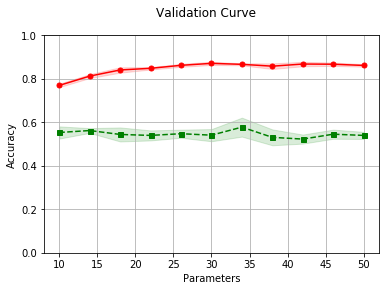

In [81]:
list_of_data=[]
train_mean_scores=[]
train_stds=[]
validation_mean_scores=[]
validation_stds=[]
cv=5
for num in param_of_num_leaves:
    param['num_leaves']=num
    train_mean_score,train_std,validation_mean_score,validation_std=\
        compute_cross_val_score(param,X_train_data,y_train_data,cv=cv,valid_set_c=False)
    train_mean_scores.append(train_mean_score)
    train_stds.append(train_std)
    validation_mean_scores.append(validation_mean_score)
    validation_stds.append(validation_std)
train_datas,valid_datas=(np.array(train_mean_scores),np.array(train_stds)),(np.array(validation_mean_scores),np.array(validation_stds))
plot_validation_curve(param_of_num_leaves,valid_datas,train_datas)

{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 10}
{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 14}


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 18}
{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 22}


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 26}


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 30}
{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 34}


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 38}
{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 42}


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 46}


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 50}


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


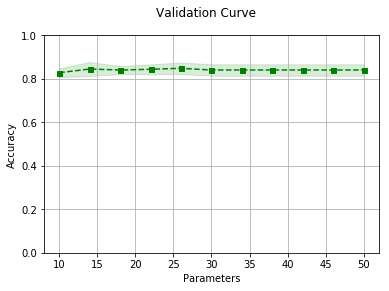

In [25]:
train_data=lgb.Dataset(X_train_data,label=y_train_data,categorical_feature=[0,1],free_raw_data=False)
param_of_num_leaves=list(range(10,51,4))
param={'objective':'binary','metric':'binary_error'}
cross_val_mean_score=[]
cross_val_mean_std=[]
list_of_param=[]
for inum in param_of_num_leaves:
    
    param['num_leaves']=inum
    print(param)
    list_of_param.append(param.copy())
    eval_hist=lgb.cv(param,train_data,num_boost_round=1000,nfold=5,early_stopping_rounds=10,verbose_eval=None)
    #scores_dict=lgb.cv(param,train_data,num_boost_round=1000,nfold=5,early_stopping_rounds=10,verbose_eval=10)
    cross_val_mean_score.append(eval_hist['binary_error-mean'][-1])
    cross_val_mean_std.append(eval_hist['binary_error-stdv'][-1])
plot_validation_curve(param_of_num_leaves,(1.0-np.array(cross_val_mean_score),np.array(cross_val_mean_std)))

In [24]:
list_of_param

[{'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 10},
 {'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 14},
 {'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 18},
 {'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 22},
 {'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 26},
 {'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 30},
 {'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 34},
 {'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 38},
 {'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 42},
 {'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 46},
 {'objective': 'binary', 'metric': 'binary_error', 'num_leaves': 50}]

In [58]:
np.array(list_of_data)[:,0]

array([0.71099888, 0.75982043, 0.78170595, 0.80527497, 0.79573513,
       0.79405163, 0.80864198, 0.7962963 ])

In [53]:
dict(zip(param_of_num_leaves,list_of_data))

{10: (0.7109988776655444,
  0.0007936103043620288,
  0.5634118967452301,
  0.008837270341202942),
 14: (0.7598204264870931,
  0.005555272130534063,
  0.574635241301908,
  0.018304721021661172),
 18: (0.7817059483726151,
  0.005722805290227617,
  0.5476992143658811,
  0.023381219591469906),
 22: (0.8052749719416387,
  0.004418635170601455,
  0.5656565656565657,
  0.032411962016147405),
 26: (0.7957351290684623,
  0.002861402645113776,
  0.574635241301908,
  0.02808079910930821),
 30: (0.7940516273849606,
  0.020029818515796556,
  0.55331088664422,
  0.011110544261068086),
 34: (0.808641975308642,
  0.010132138094987534,
  0.5881032547699214,
  0.01930937209212711),
 38: (0.7962962962962964,
  0.007273558584071691,
  0.5578002244668911,
  0.02479317848975814)}

In [26]:
np.argmin(scores_dict['binary_error-mean']),scores_dict['binary_error-mean'][40]

(40, 0.15935182338240444)

In [27]:
bst=lgb.train(param,train_data,num_boost_round=41,categorical_feature=[0,1])

In [28]:
compute_acc(y_train_data,bst.predict(X_train_data).ravel())

0.9046015712682379

In [18]:
test_pred=(bst.predict(X_test_data).ravel()>0.5).astype(np.int)

In [19]:
test_data_count['Survived']=test_pred
test_data_count[['PassengerId','Survived']].to_csv('c:/users/dell/desktop/gender_submission.csv',index=False)

In [10]:
import lightgbm as lgb
# 准备数据
train_data=lgb.Dataset(train_data_X,train_data_y)
valid_data=lgb.Dataset(dev_data_X,dev_data_y,reference=train_data)

In [113]:
# setting parameters  dict type
param={'num_leaves':14,'num_iterations':40,'objective':'binary'}
param['metric']='binary_error'

In [122]:
# setting parameters  dict type
param={'num_leaves':15,'num_iterations':154,'objective':'binary'}
param['metric']='binary_error'

In [123]:
# training 
num_boost_round=10
bst=lgb.train(param,train_data,num_boost_round,valid_sets=[valid_data],verbose_eval=50)

C:\Users\dell\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's binary_error: 0.186567
[100]	valid_0's binary_error: 0.197761
[150]	valid_0's binary_error: 0.19403


In [124]:
bst.num_trees()

154

In [129]:
train_pred_y=bst.predict(data_X_train)
compute_acc(data_y_train,train_pred_y)

0.8585858585858586

In [131]:
dev_y_pred=bst.predict(dev_data_X)
compute_acc(dev_data_y,dev_y_pred)

0.8097014925373134

In [57]:
test_y_pred=bst.predict(test_data_X)

In [58]:
test_data_origin['Survived']=np.where(test_y_pred>=0.5,1,0)

In [59]:
test_data_origin[['PassengerId','Survived']].to_csv('c:/users/dell/desktop/gender_submission.csv',index=False)

In [52]:
bst.params

{'metric': 'binary_error', 'num_leaves': 15, 'objective': 'binary'}

In [64]:
# scikit api 参数调优
data_X_train=full_pipeline_std.fit_transform(train_data_count).toarray()
data_y_train=train_data_count['Survived'].values.ravel()
data_X_train[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        3.        ,  1.        ,  0.        ,  1.        , -0.56573646,
       -0.50244517, -0.49697568])

In [83]:
data_train=lgb.Dataset(data_X_train,data_y_train,silent=True)
params={'boosting_type':'gbdt',
        'objective':'binary',
        'learning_rate':0.1,
        'num_leaves':31,
        'max_depth':5,        
       }
cv_results=lgb.cv(params,data_train,num_boost_round=1000,nfold=5,stratified=True,shuffle=True,metrics='binary_error',early_stopping_rounds=50,\
                  verbose_eval=10,show_stdv=True,seed=0)
print ('\nbest n_estimators:',len(cv_results['binary_error-mean']))
print ('best cv-score:',cv_results['binary_error-mean'][-1])

[10]	cv_agg's binary_error: 0.189645 + 0.0259372
[20]	cv_agg's binary_error: 0.180701 + 0.0274235
[30]	cv_agg's binary_error: 0.176193 + 0.021359
[40]	cv_agg's binary_error: 0.178428 + 0.0252489
[50]	cv_agg's binary_error: 0.173952 + 0.0149303
[60]	cv_agg's binary_error: 0.166087 + 0.0170612
[70]	cv_agg's binary_error: 0.164976 + 0.0189233
[80]	cv_agg's binary_error: 0.158241 + 0.0147091
[90]	cv_agg's binary_error: 0.166106 + 0.0130923
[100]	cv_agg's binary_error: 0.162716 + 0.0124947
[110]	cv_agg's binary_error: 0.161586 + 0.0144549
[120]	cv_agg's binary_error: 0.162716 + 0.011969
[130]	cv_agg's binary_error: 0.158228 + 0.0136617
[140]	cv_agg's binary_error: 0.160475 + 0.0112666
[150]	cv_agg's binary_error: 0.161593 + 0.0126621
[160]	cv_agg's binary_error: 0.162716 + 0.0143578
[170]	cv_agg's binary_error: 0.160482 + 0.0124245
[180]	cv_agg's binary_error: 0.163859 + 0.0124669
[190]	cv_agg's binary_error: 0.161612 + 0.0113643
[200]	cv_agg's binary_error: 0.163859 + 0.0124593

best n_est

In [82]:
cv_results.keys()

dict_keys(['binary_error-mean', 'binary_error-stdv'])

In [85]:
#cv_results.items()
# 第一次 search 粗略
from sklearn.model_selection import GridSearchCV
model_lgb=lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=31,max_depth=5,learning_rate=0.1,n_estimators=154,objective='binary',\
                             n_jobs=-1,silent=True,importance_type='split')
param_grid1={'num_leaves':[15,28,31,45,64],'max_depth':[4,5,6]}
gs1=GridSearchCV(model_lgb,param_grid=param_grid1,scoring='accuracy',iid='warn',n_jobs=-1,cv=5)

In [86]:
gs1.fit(data_X_train,data_y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=154, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'num_leaves': [15, 28, 31, 45, 64], 'max_depth': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [88]:
gs1.best_score_,gs1.best_estimator_

(0.8338945005611672,
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.1, max_depth=5,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=154, n_jobs=-1, num_leaves=15, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0))

In [130]:
# K折交叉验证
from sklearn.model_selection import cross_val_score
scores=cross_val_score(gs1,data_X_train,data_y_train,cv=5,n_jobs=-1,scoring='accuracy')
scores

array([0.80446927, 0.79888268, 0.84831461, 0.82022472, 0.85310734])

In [92]:
scores.mean()

0.8249997251565455

In [94]:
# 第二次 search 精细
param_grid2={'num_leaves':[11,13,15,17,19],'max_depth':[4,5]}
gs2=GridSearchCV(model_lgb,param_grid=param_grid2,scoring='accuracy',iid='warn',cv=5)
gs2.fit(data_X_train,data_y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=154, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_leaves': [11, 13, 15, 17, 19], 'max_depth': [4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [95]:
gs2.best_score_,gs2.best_estimator_

(0.8338945005611672,
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.1, max_depth=5,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=154, n_jobs=-1, num_leaves=15, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0))

In [97]:
scores=cross_val_score(gs2,data_X_train,data_y_train,cv=5,scoring='accuracy')
scores,scores.mean()

(array([0.79329609, 0.80446927, 0.85393258, 0.82022472, 0.85310734]),
 0.8250060022264092)

In [103]:
test_y_lgb_pred=gs2.predict(test_data_X)

In [104]:
test_data_origin['Survived']=np.where(test_y_lgb_pred.ravel()>0.5,1,0)
test_data_origin[['PassengerId','Survived']].to_csv('c:/users/dell/desktop/gender_submission.csv',index=False)

In [108]:
param_grid3={'num_leaves':[14,15,16],"n_estimators":[40,151]}
gs3=GridSearchCV(model_lgb,param_grid=param_grid3,scoring='accuracy',iid='warn',cv=5)
gs3.fit(data_X_train,data_y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=154, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_leaves': [14, 15, 16], 'n_estimators': [40, 151]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [109]:
gs3.best_score_,gs3.best_estimator_

(0.8327721661054994,
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', learning_rate=0.1, max_depth=5,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=151, n_jobs=-1, num_leaves=15, objective='binary',
         random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0))

尽管模型已经过拟合，但仍然没有达到我要的精度要求，在这种情况下，是什么问题呢？考虑数据的特征工程